In [3]:
import networkx as nx
import numpy as np
from tqdm import tqdm
import torch
from src.mixturemodel import MixtureModel
from src.sbm import generate_sbm, MySbmFromScratch
from src.utils import random_permute_adj
import torch.multiprocessing as mp
import matplotlib.pyplot as plt

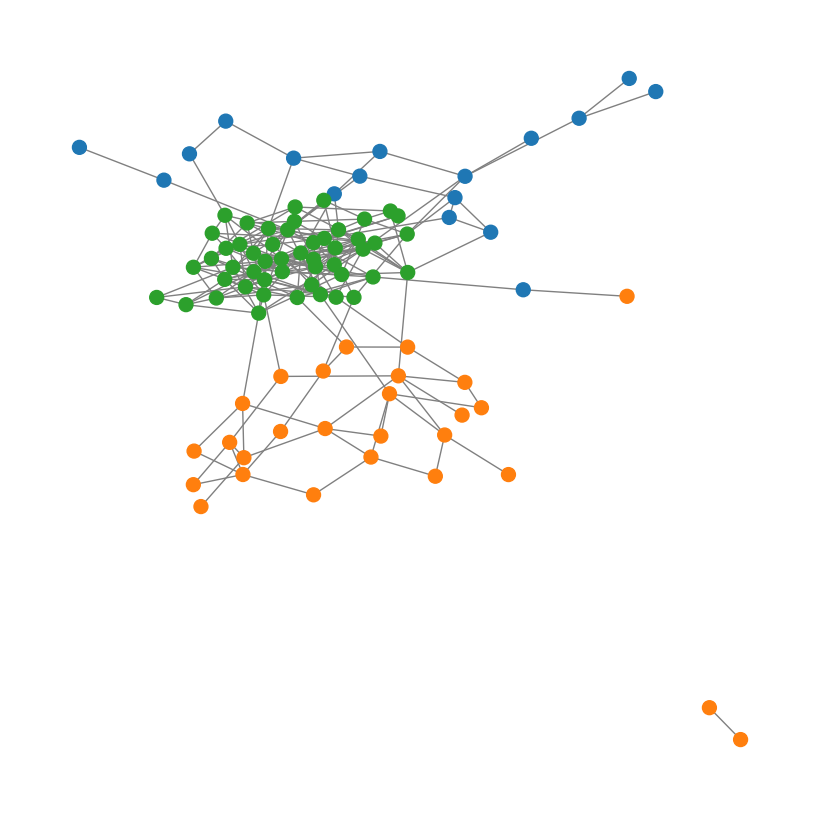

In [4]:
n=100
k=3

sbm = MySbmFromScratch()

sbm.generate_graph(N=n, K=k, _lambda=0.1, multiplier=0.1, alpha=1.5)
sbm.plot_graph()
model = MixtureModel(sbm.adj, sbm.adj.shape[0], k, device="cuda")

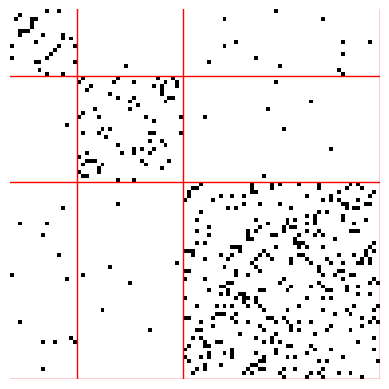

In [5]:
sbm.plot_adj()

100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


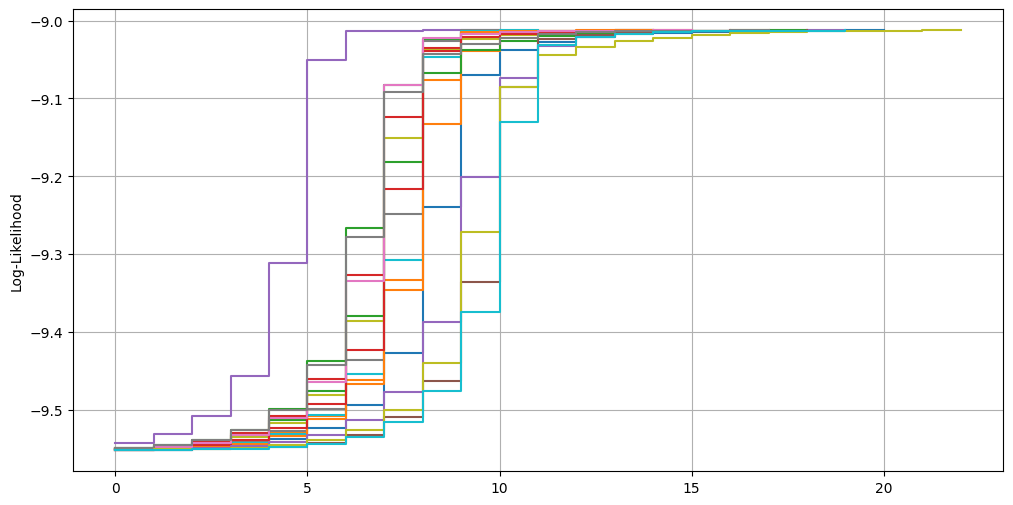

In [6]:
mp.set_start_method('spawn', force=True)

model = MixtureModel(sbm.adj, sbm.adj.shape[0], k, device='cuda')
resultats = model.em_parallelised_2( return_params=True, init="", max_it=50, tolerance=1e-4, num_inits=20)
model.plot_logs_path() # init = "" signifie une initialisation aléatoire pour tau

100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


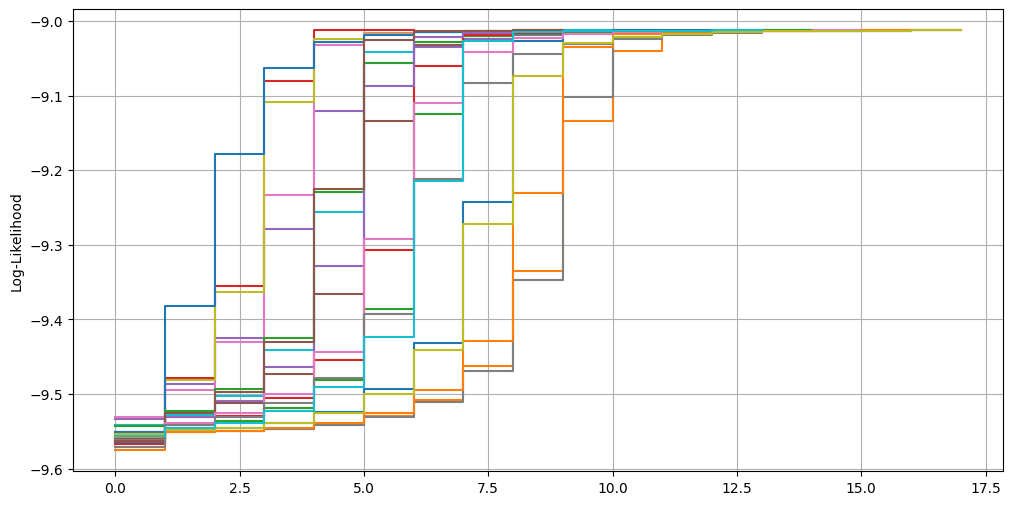

In [7]:
mp.set_start_method('spawn', force=True)

model = MixtureModel(sbm.adj, sbm.adj.shape[0], k, device='cuda') # K = 5
resultats = model.em_parallelised_2( return_params=True, init="Sparse", max_it=50, tolerance=1e-4, num_inits=20)
model.plot_logs_path()

In [5]:
list_inits = ["", "Sparse", "Kmeans"]
list_Q = [3, 7, 15]
list_n = [100, 500, 1000]
all_res = {}

for init in list_inits:
    all_res[init] = {}

for Q in list_Q:
    for n in list_n:
        sbm = MySbmFromScratch()

        sbm.generate_graph(N=n, K=Q, _lambda=0.1, multiplier=0.1, alpha=1.5)
        for init in tqdm(list_inits, desc=f'computing for n = {n} & Q = {Q}'):
            mp.set_start_method('spawn', force=True)
            model = MixtureModel(sbm.adj, sbm.adj.shape[0], Q, device='cuda')
            resultats = model.em_parallelised_2( return_params=True, init=init, max_it=50, tolerance=1e-4, num_inits=20,
                                                verbose=False)
            all_res[init][f"{n},{Q}"] = model.all_res
            all_res[init][f"like {n}, {Q}"] = resultats["likelihood"]

            

computing for n = 100 & Q = 3:   0%|          | 0/3 [00:00<?, ?it/s]

computing for n = 1000 & Q = 15:   0%|          | 0/3 [00:00<?, ?it/s]Process Process-536:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/onyxia/work/PGM_MVA/src/mixturemodel.py", line 30, in worker
    alpha, pi, tau, logs_like = model.em(tau=tau_init, max_it=max_it, tolerance=tolerance, verbose=False, log_path=True)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/onyxia/work/PGM_MVA/src/mixturemodel.py", line 261, in em
    tau = self._fixed_point_algorithm(alpha, pi, tau, tolerance, max_it_fp)  # E step
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/onyxia/work/PGM_MVA/src/mixturemodel.py", line 237, in _fixed_point_algorithm
   

In [36]:
for key in all_res[""].keys():
    if key[:4] == "like":
        print(f"Likelihood with parameters {key} & random inits :", round(all_res[""][key],2))

Likelihood with parameters like 100, 3 & random inits : -14.75
Likelihood with parameters like 500, 3 & random inits : -40.4
Likelihood with parameters like 1000, 3 & random inits : -96.73
Likelihood with parameters like 100, 7 & random inits : -7.43
Likelihood with parameters like 500, 7 & random inits : -20.86
Likelihood with parameters like 1000, 7 & random inits : -36.21
Likelihood with parameters like 100, 15 & random inits : -3.81
Likelihood with parameters like 500, 15 & random inits : -17.21
Likelihood with parameters like 1000, 15 & random inits : -21.14


In [35]:
for key in all_res["Sparse"].keys():
    if key[:4] == "like":
        print(f"Likelihood with parameters {key} & random inits :", round(all_res["Sparse"][key],2))

Likelihood with parameters like 100, 3 & random inits : -14.75
Likelihood with parameters like 500, 3 & random inits : -40.4
Likelihood with parameters like 1000, 3 & random inits : -96.73
Likelihood with parameters like 100, 7 & random inits : -7.43
Likelihood with parameters like 500, 7 & random inits : -20.87
Likelihood with parameters like 1000, 7 & random inits : -36.36
Likelihood with parameters like 100, 15 & random inits : -3.8
Likelihood with parameters like 500, 15 & random inits : -17.16
Likelihood with parameters like 1000, 15 & random inits : -20.73


In [34]:
for key in all_res["Kmeans"].keys():
    if key[:4] == "like":
        print(f"Likelihood with parameters {key} & random inits :", round(all_res["Kmeans"][key],2))

Likelihood with parameters like 100, 3 & random inits : -14.74
Likelihood with parameters like 500, 3 & random inits : -40.4
Likelihood with parameters like 1000, 3 & random inits : -96.73
Likelihood with parameters like 100, 7 & random inits : -7.37
Likelihood with parameters like 500, 7 & random inits : -20.77
Likelihood with parameters like 1000, 7 & random inits : -35.39
Likelihood with parameters like 100, 15 & random inits : -3.83
Likelihood with parameters like 500, 15 & random inits : -17.15
Likelihood with parameters like 1000, 15 & random inits : -18.77


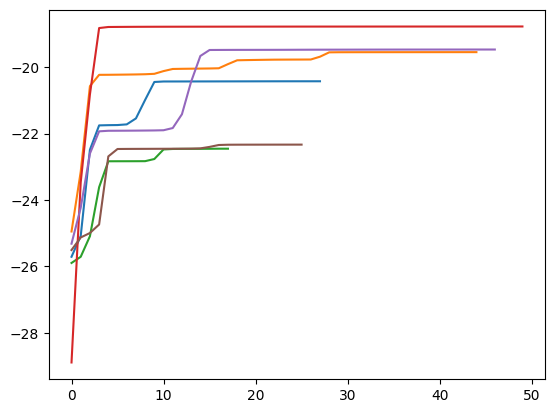

In [39]:
for idx in all_res["Kmeans"]["1000,15"]:
    plt.plot(idx["logs_like"])